In [334]:
# Connecting to database
import os.path
import yaml
from sqlalchemy import create_engine, text
from sqlalchemy.orm import Session

config_path = os.path.expanduser('~\\.sqlalchemy\\config.yaml')

with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

db_path = (
    f"postgresql://{config['username']}:{config['password']}"
    f"@{config['host']}:{config['port']}/{config['db_name']}"
)
engine = create_engine(db_path)
conn = engine.connect()


In [335]:
# Setting up the Registry
from sqlalchemy.orm import registry
mapper_registry = registry()
Base = mapper_registry.generate_base()


In [336]:
# Declaring Mapped Classes (using base)
class KoreanLastname(Base):
    __tablename__ = 'korean_lastname'

    lastname = Column(String(5), primary_key=True)
    ratio = Column(Float(8))


class KoreanFirstname(Base):
    __tablename__ = 'korean_firstname'

    firstname = Column(String(5), primary_key=True)
    ratio = Column(Float(8))


class AgeStat(Base):
    __tablename__ = 'age_stat'

    age = Column(String(5), primary_key=True)
    ratio = Column(Float(8))


class RegionStat(Base):
    __tablename__ = 'region_stat'

    region = Column(String(8), primary_key=True)
    ratio = Column(Float(8))


class SexStat(Base):
    __tablename__ = 'sex_stat'

    sex = Column(String(2), primary_key=True)
    ratio = Column(Float(8))


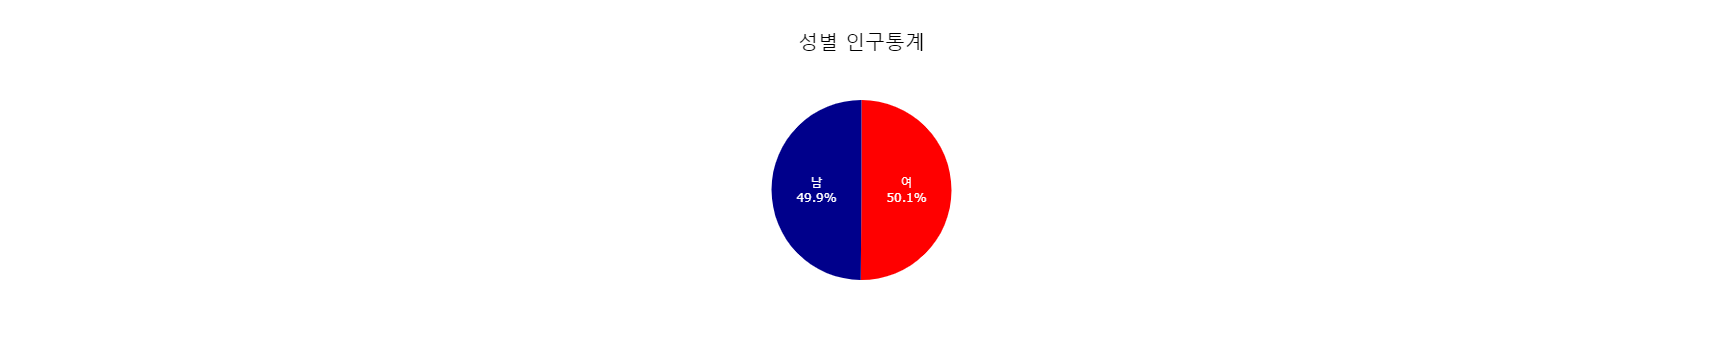

In [337]:
import plotly.express as px
import pandas as pd
from sqlalchemy import select

# 성별 인구통계
sex_stat_df = pd.read_sql(select(SexStat), conn)
fig = px.pie(sex_stat_df, values='ratio', names='sex', color='sex',
             color_discrete_map={'여': 'red', '남': 'darkblue'},
             labels={'ratio': '비율', 'sex': '성'},
             title='성별 인구통계')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=False, title_font_color='black', title_x=0.5,
                  title_font_size=20)
fig.show()


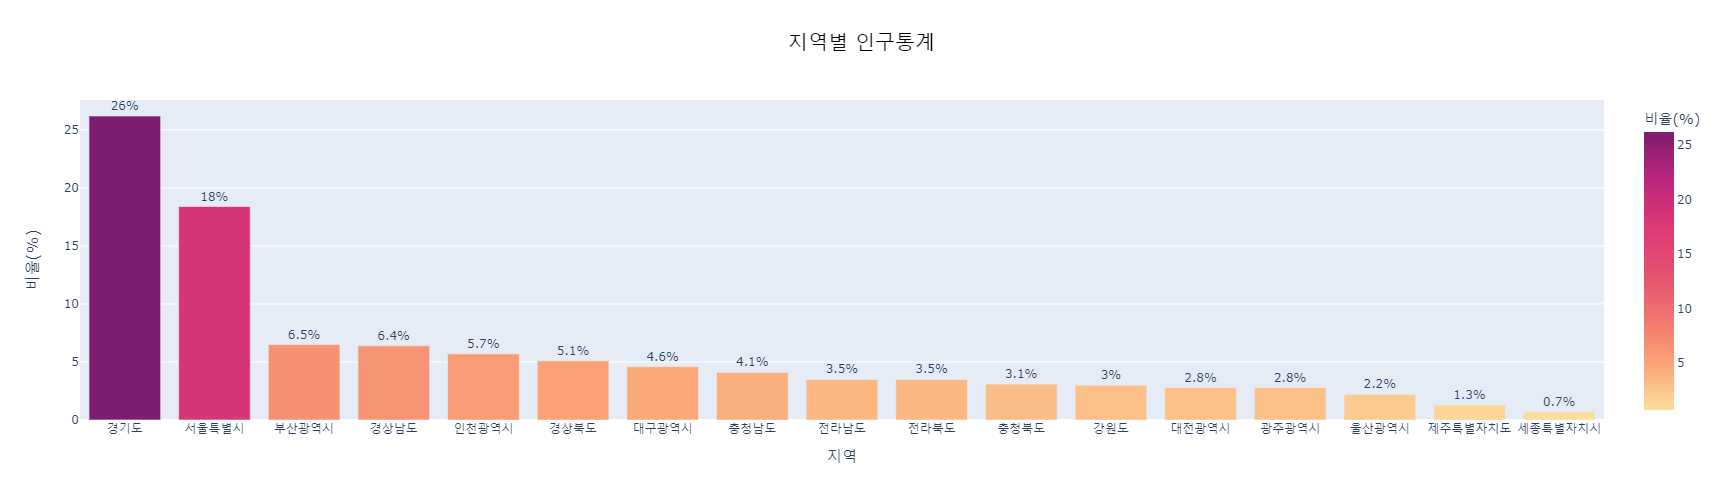

In [338]:
# 지역별 인구통계
def percent_format(x, precision):
    return round(x*100, precision)

region_stat_df = pd.read_sql(select(RegionStat), conn)
region_stat_df.sort_values(by=['ratio'], axis=0, ascending=False, inplace=True)
region_stat_df['ratio'] = region_stat_df['ratio'].apply(
    percent_format, args=(1,)
)

fig = px.bar(region_stat_df, x="region", y="ratio", color='ratio', height=500,
             color_continuous_scale='Sunsetdark',
             text='ratio', title='지역별 인구통계',
             labels={'ratio': '비율(%)', 'region': '지역'})
fig.update_traces(texttemplate='%{text:.2}%', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',
                  title_font_color='black', title_x=0.5, title_font_size=20)
fig.update_xaxes(title_font=dict(size=15))
fig.update_yaxes(title_font=dict(size=15))
fig.show()


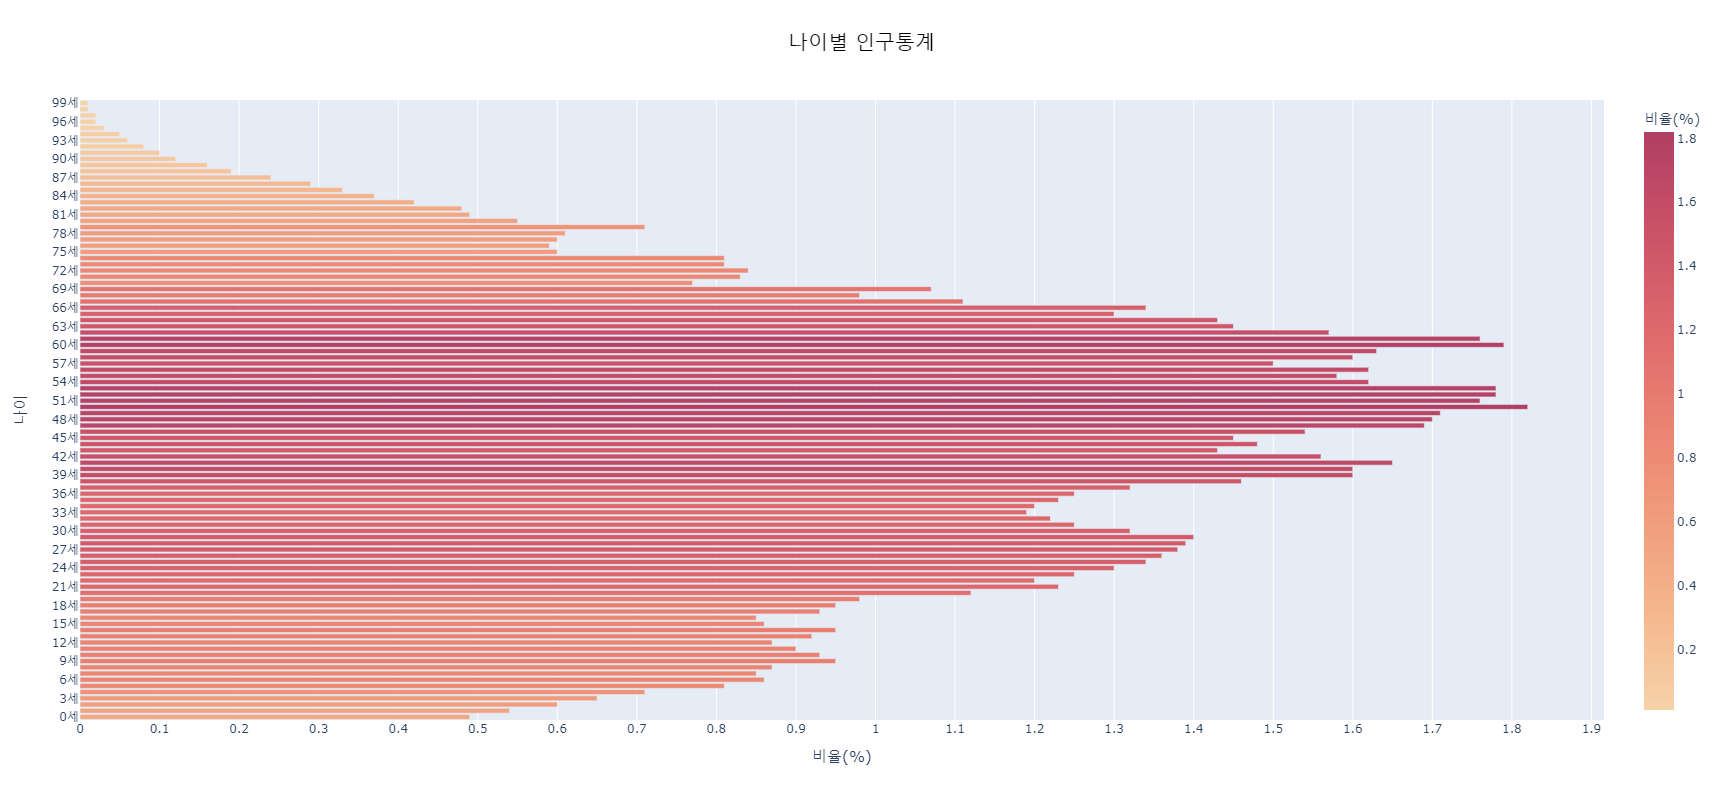

In [339]:
# 나이별 인구통계
age_stat_df = pd.read_sql(select(AgeStat), conn)
age_stat_df['ratio'] = age_stat_df['ratio'].apply(percent_format, args=(4,))

fig = px.bar(age_stat_df, x="ratio", y="age", orientation='h',
             title='나이별 인구통계', height=800, color='ratio',
             color_continuous_scale='Redor',
             labels={'ratio': '비율(%)', 'age': '나이'})
fig.update_layout(title_font_color='black', title_x=0.5, title_font_size=20)
fig.update_xaxes(title_font=dict(size=15), dtick=0.1)
fig.update_yaxes(title_font=dict(size=15))
fig.show()


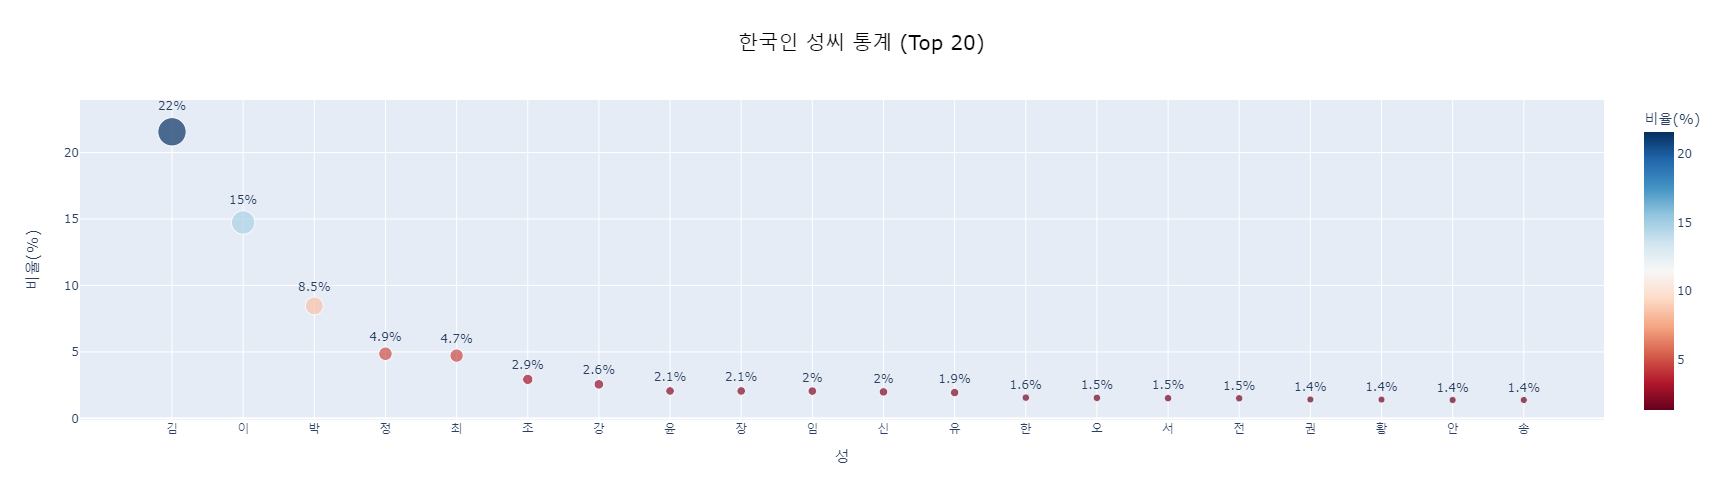

In [340]:
# 한국인 성씨 통계
korean_lastname_df = pd.read_sql(select(KoreanLastname), conn)
korean_lastname_df.sort_values(by=['ratio'], axis=0, ascending=False,
                               inplace=True)
korean_lastname_df = korean_lastname_df.head(20)
korean_lastname_df['ratio'] = korean_lastname_df['ratio'].apply(
    percent_format, args=(2,))

fig = px.scatter(korean_lastname_df, x="lastname", y="ratio", size="ratio",
                 color="ratio", title='한국인 성씨 통계 (Top 20)',
                 color_continuous_scale='RdBu', text="ratio",
                 labels={'ratio': '비율(%)', 'lastname': '성'})
fig.update_traces(texttemplate='%{text:.2}%', textposition='top center')
fig.update_layout(title_font_color='black', title_x=0.5, title_font_size=20,
                  height=500)
fig.update_xaxes(title_font=dict(size=15))
fig.update_yaxes(title_font=dict(size=15))
fig.show()


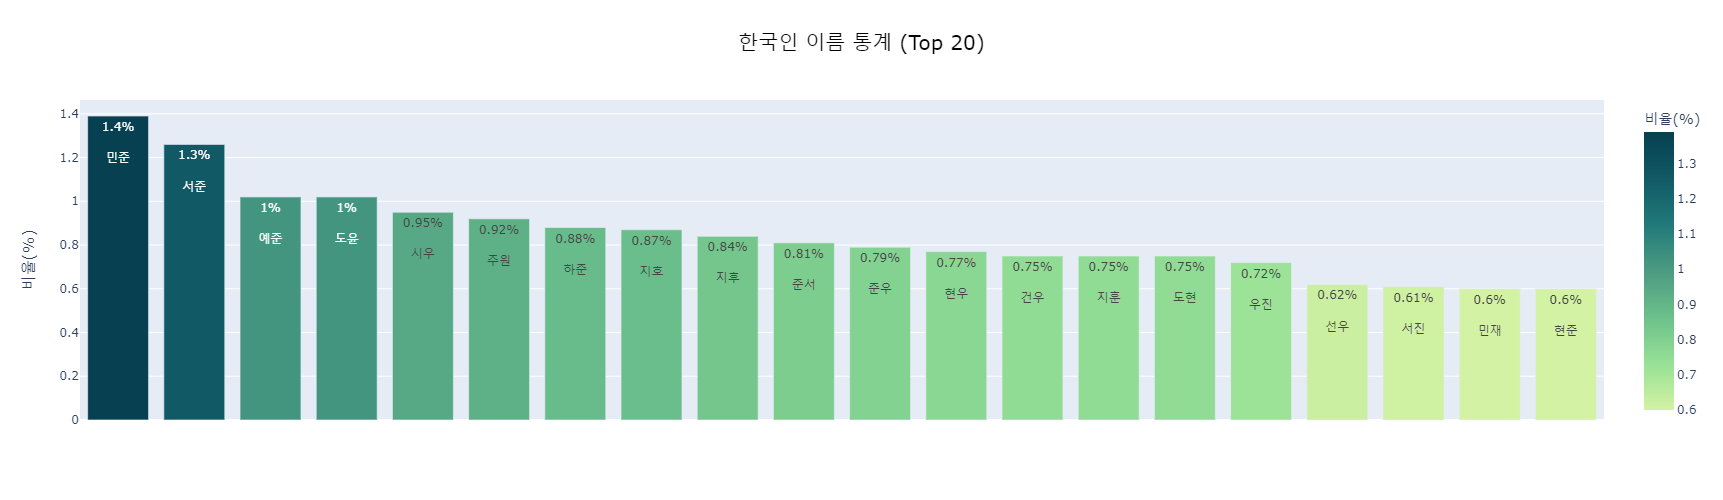

In [341]:
# 한국인 이름 통계
korean_firstname_df = pd.read_sql(select(KoreanFirstname), conn)
korean_firstname_df.sort_values(by=['ratio'], axis=0, ascending=False,
                                inplace=True)
korean_firstname_df = korean_firstname_df.head(20)
korean_firstname_df['ratio'] = korean_firstname_df['ratio'].apply(
    percent_format, args=(2,))

name = korean_firstname_df['firstname']
fig = px.bar(korean_firstname_df, x='firstname', y='ratio', color='ratio',
             title='한국인 이름 통계 (Top 20)', text='ratio', height=500,
             labels={'ratio': '비율(%)', 'firstname': '이름'},
             color_continuous_scale='Emrld')
fig.update_traces(texttemplate='%{text:.2}%<br><br>%{x}',
                  textposition='inside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',
                  title_font_color='black', title_x=0.5, title_font_size=20)
fig.update_xaxes(visible=False)
fig.update_yaxes(title_font=dict(size=15))
fig.show()
